# How do we define fringe transmission?  What part of the signal are we trying to calibrate?
Different fringe patterns have been shown, and the effect of the wavelength calibration on the spectra was illustrated via the etalon, extended source, and internal calibration source observations. The fringe patterns however are shown superimposed on the spectral baseline of the sources. Different sources have different spectral baselines. Here we look for a way to disentangle the fringe pattern from the source intrinsic spectrum, for the different types of sources considered. In this notebook we look at the etalon data first. The concepts described here apply much the same to the broader exercise of calibrating the MRS fringes from extended and point sources.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

from numpy import (flipud,mean,diff,array,linspace,pi)
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline

from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

We load the images for one band of the MRS:
* MTS 800K BB extended source observed through etalon "ET1A"
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
etal_source_sci,etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

We subtract background exposures where available.

In [3]:
# perform transform
etal_source_bkgsubtr = etal_source_sci-etal_source_bkg

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [4]:
etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(etal_source_bkgsubtr)

What happens when a blackbody spectrum is observed through a Fabry-Pérot resonator (a.k.a. an etalon)? The observation of the MTS extended source seen through etalon ET1A shows an example of what happens. Where there is constructive interference one sees peaks in the spectrum. Where there is destructive interference one sees noise. Important to take note:
* The spacing of the peaks depends on the geometric and optical properties of the etalon
* Etalons can be modeled using a Fabry-Pérot transmittance function that depends on broad design parameters such as the reflectivity of the etalon and optical thickness (refractive index of constituent material multiplied by geometric thickness). Mathematically:  
  
$$  
T_{e} = \frac{1}{1 + F\cdot \sin^2\left(\frac{\delta}{2}\right)}
$$  
where the "finesse" F of the etalon relates to the etalon reflectivity R as  
$$
F = \frac{4R}{(1-R)^2}
$$  
and the phase differense between successive peaks $\delta$ relates to the etalon optical thickness D as:  
  
$$  
\delta = 2\pi\sigma\cdot 2D\cdot \cos(\theta)  - (\phi-\pi)  
$$  
where $\sigma$ stands for wavenumber, $\theta$ is the light incidence angle, and $\phi$ is the phase change introduced upon reflection ($\phi$=$\pi$ for metals).
  
In order to compare the etalon spectrum to the transmittance function, the former is normalized by:
* fitting the etalon lines (e.g. assume Guassian distribution)
* connecting the peaks of the fitted lines with a univariate spline
* dividing the data by the univariate spline

In [5]:
# Pixel trace in MRS slice
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=0.)

# Etalon spectrum peaks
etal_source_peaks = funcs.find_peaks(etal_source_oddevencorr[ypos,xpos], thres=0.3, min_dist=6)
# Fit etalon lines
fitparams,errors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos],etal_source_peaks,fit_func='gauss1d',sigma0=0.002)
lineheights = funcs.get_amplitude(fitparams=fitparams,fitting_flag=fitting_flag)
linecenters = funcs.get_linecenter(fitparams=fitparams,fitting_flag=fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(linecenters,lineheights,k=3,ext=3)
etal_source_peakprofile = interpolator(lambdaMap[ypos,xpos])

<IPython.core.display.Javascript object>


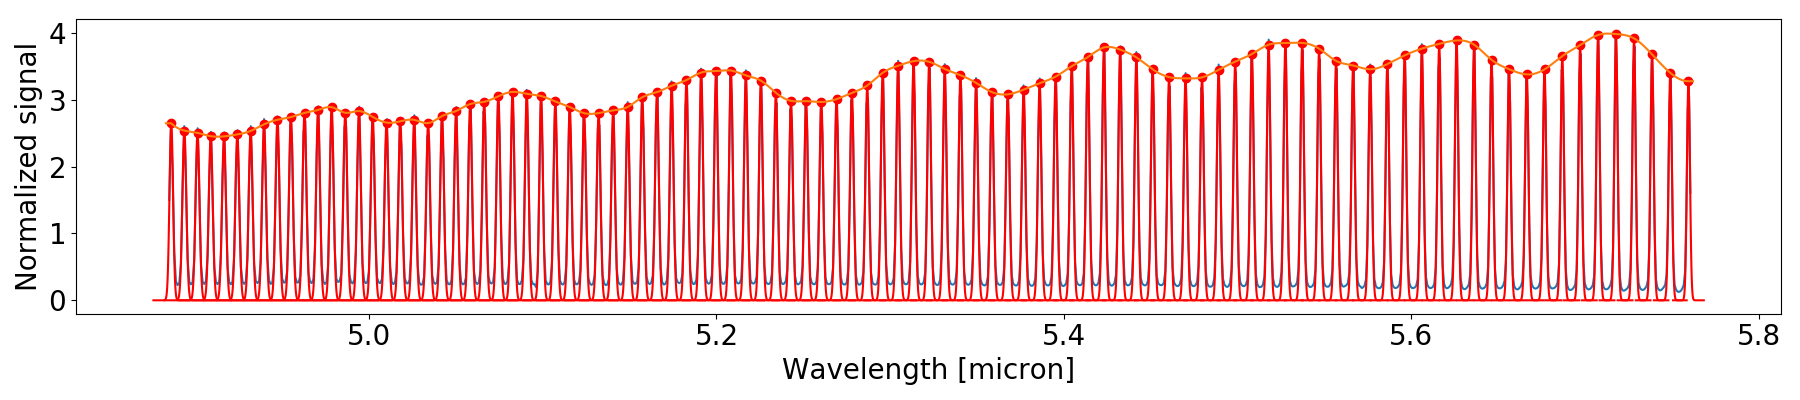

<IPython.core.display.Javascript object>


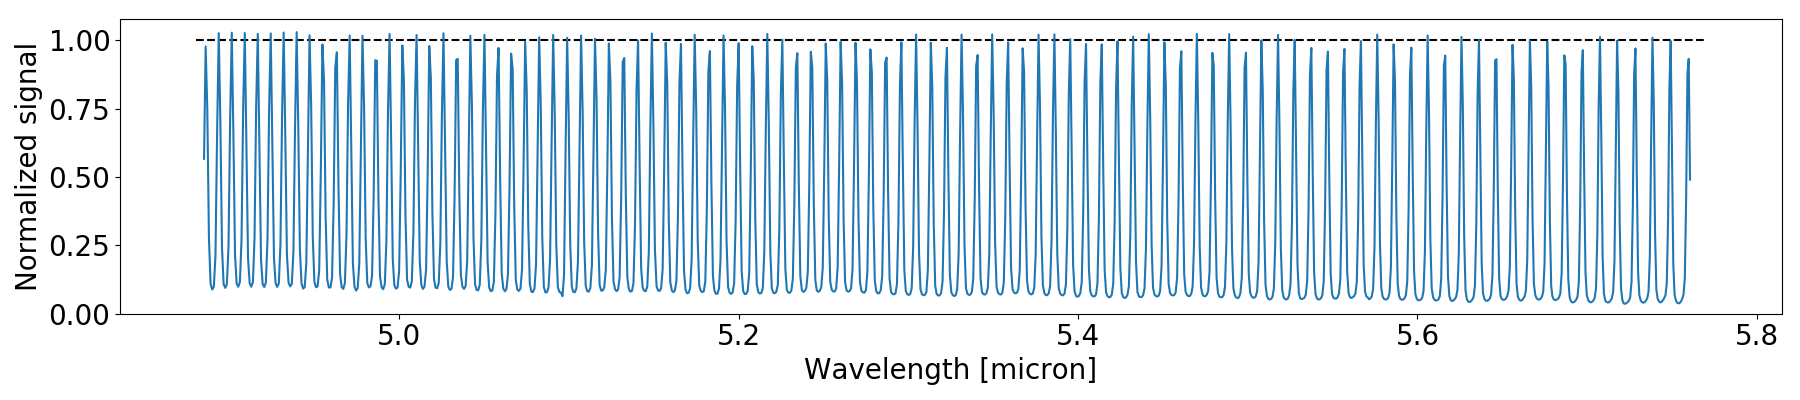

In [6]:
# let's look at the result
plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos])
funcs.plot_etalon_fit(fitparams=fitparams,fitting_flag=fitting_flag)
plt.plot(linecenters,lineheights,'ro')
plt.plot(lambdaMap[ypos,xpos],etal_source_peakprofile)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos]/etal_source_peakprofile)
plt.hlines(1,4.88,5.77,linestyle='dashed')
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

### Remarks:
* Fitting an energy distribution to the etalon data lifts the sampling effects from the data.
* The spline, taken through the fitted etalon line peaks, illustrates a beating of frequencies with different amplitudes. Given that the apparent depth of the low-frequency beating varies with wavelength, this implies that the amplitude of the beating-producing fringe may vary with wavelength.
* It is obviously not correct to normalize the etalon spectrum only based on the above-defined spline, since this omits the beating-producing fringe frequency from the analysis. Additionally a periodicity is introduced to the spectral continuum of the normalized signal (spline connecting the troughs of the normalized signal). For the purpose of this section we omit this concern until later in this notebook.

### Test 1: Determining etalon properties from the data (optical thickness)
Information about the optical properties of an etalon can be attained by studying the etalon lines in wavenumber space. Assuming that the etalon reflecting surfaces (/mirrors) are plane-parallel, and that the incidence angle is small, subsequent peaks in transmission occur at a constant distance from one another. This distance relates to the optical thickness of the etalon itself.

In [7]:
linecenters_wavelength     = linecenters.copy()         # microns
linecenters_wavenumber     = flipud(10000./linecenters_wavelength) # cm-1
mean_linecenter_separation = mean(diff(linecenters_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,linecenters_wavenumber[1:-2],diff(linecenters_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_linecenter_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_linecenter_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 3.17 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1578.86 um


<IPython.core.display.Javascript object>


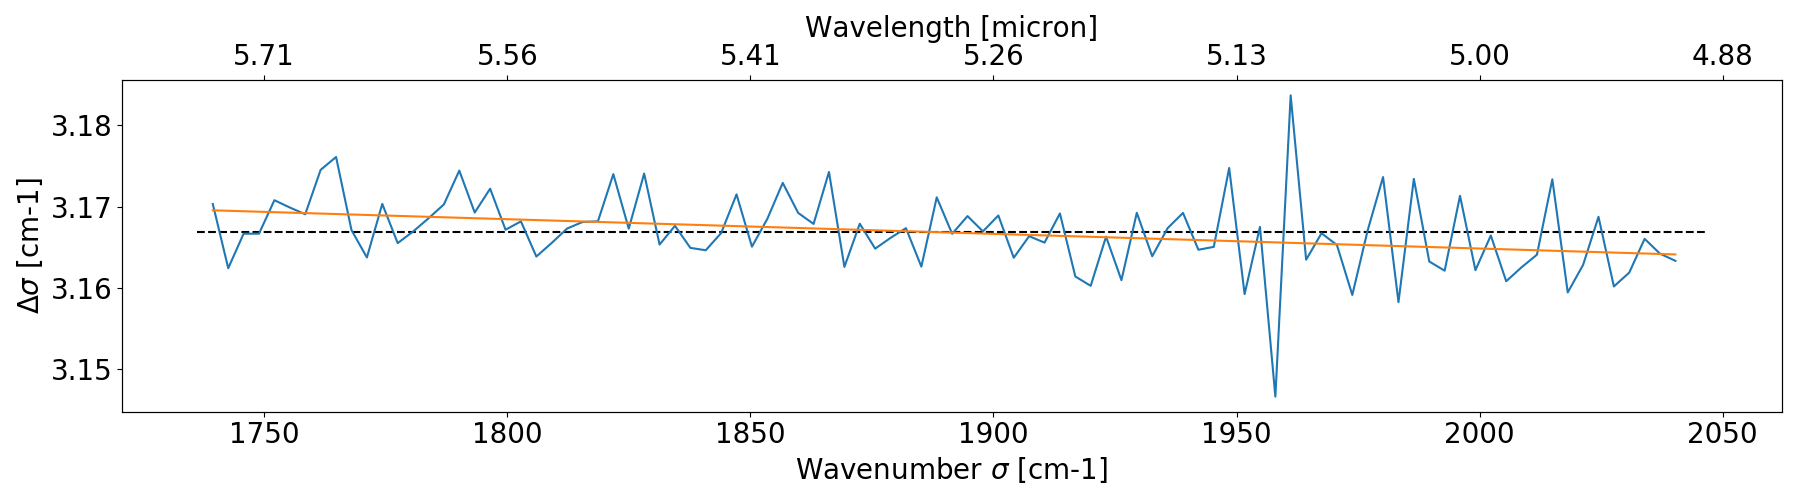

In [8]:
# Let's look at the results
fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(linecenters_wavenumber[1:-2],diff(linecenters_wavenumber)[1:-1])
axs1.plot(linecenters_wavenumber[1:-2],funcs.straight_line(linecenters_wavenumber[1:-2],*popt))
axs1.hlines(mean_linecenter_separation,linecenters_wavenumber[0],linecenters_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The MRS data of etalon ET1A, using the available wavelength calibration, tell us that the optical thickness of the etalon is approximately 1580um. The design specifications of ET1A bear an optical thickness of 1590+-5um at room temperature. Since ET1A was used at an operational temperatures of ~35K, the discrepancy in the optical thickness can be explained by thermal contraction of the etalon. However we are lacking thermal expansion coefficient data on zinc selenide (ET1A reflecting surface material) at cold temperatures to support this claim.
* We see that performing a linear regression to the distance between etalon peaks yields a non-zero slope to the line separation data. This is linked back to the continuum of the etalon data ("noise floor"). The blending of the etalon lines yields a higher continuum at short wavelengths compared to the longer wavelengths, and that is because the line separation increases with longer wavelengths (lines become less and less blended). Or are they? The spectral resolution of the MRS increases linearly over band 1A. As such the observed blending may be no blending at all, but an effect of the spectral sampling of the MRS.
* Using the linear regression information rather than the mean optical thickness value, the difference in the determined optical thickness from the low wavenumber end to the high wavenumber end is of the order of 1.2um increase.

### Test 1: Determining etalon properties from the data (intensity reflectivity)
Since we work with a normalized etalon transmission, assuming that the etalon's reflecting surfaces are made out of the same material, a single (wavelength-dependent) intensity reflectivity can be determined for the optical element. This can simply be done by looking at the spectral continuum level and relating that to the etalon finesse value (hence intensity reflectivity). The expression of reflectivity as a function of etalon transmission is a second order equation (the equation has two valid solutions, but only one lies between 0 and 1).

In [9]:
# at lower wavelength end
T_e1 = 0.1
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e1)
print ' Finesse = {} \n R1 = {} \n R2 = {} (physically valid solution)\n'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_low = R_solution2

# at higher wavelength end
T_e2 = 0.04
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e2)
print ' Finesse = {} \n R1 = {} \n R2 = {} (physically valid solution)'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_high = R_solution2

 Finesse = 9.0 
 R1 = 1.92 
 R2 = 0.52 (physically valid solution)

 Finesse = 24.0 
 R1 = 1.5 
 R2 = 0.67 (physically valid solution)


<IPython.core.display.Javascript object>


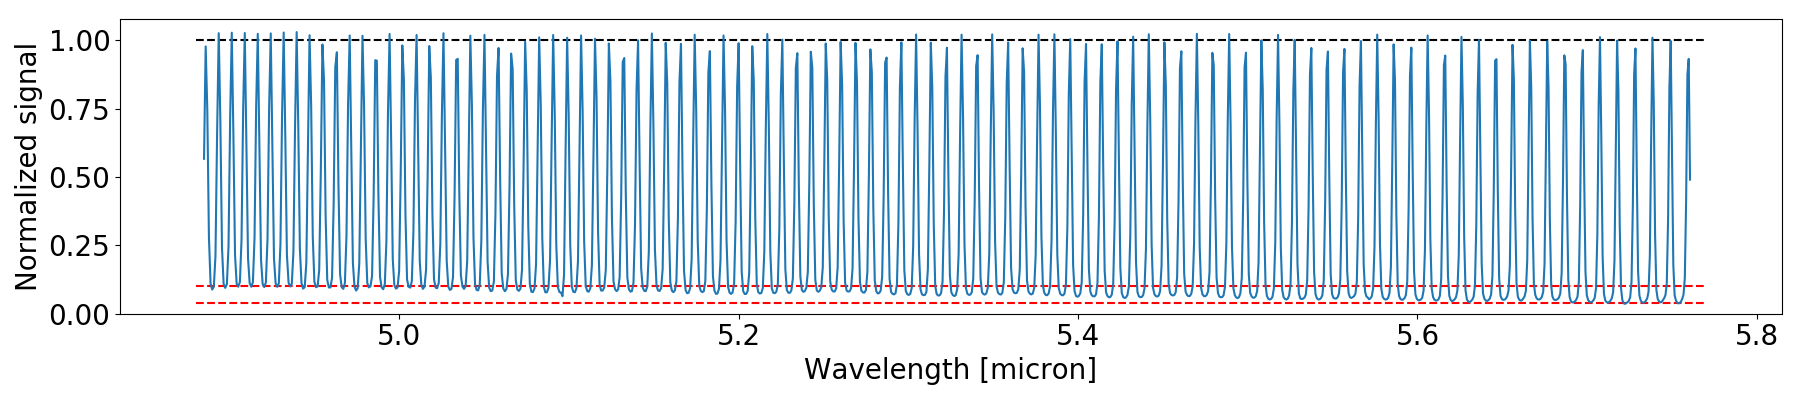

In [10]:
plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos]/etal_source_peakprofile)
plt.hlines(1,4.88,5.77,linestyle='dashed')
plt.hlines([T_e1,T_e2],4.88,5.77,'r',linestyle='dashed')
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

### Remarks:
* The design specification for the etalon ET1A is R=93%+-3% between 5um and 7.71um. Here we find R=52% @ 4.9um and R=67% @ 5.76um.
* The determined values are "guided" by the amount of blending of the etalon lines, i.e. the signal level of the troughs. If the supposition that the so-called "blending" is in fact the spectral non-resolving of the etalon lines, then the measured R and the design specification R do not negate each other. The MIRI MRS simply cannot resolve the spectral lines. This also implies however (just to be explicit) that the reflectivity properties of the etalon cannot be constrained with the MIRI MRS.

### Test 2: Modeling an etalon with a transmittance function
We use the information derived from the data to model the transmittance function of etalon ET1A.

In [11]:
wavelengths = linspace(4.88,5.77,10000)      # um
wavenumbers = flipud(10000./wavelengths)     # cm-1

R   = flipud(linspace(R_low,R_high,10000))   # [-]
D   = 1./(2*mean_linecenter_separation)      # cm
phi = pi+0.8                                 # rad

T_e = funcs.FPfunc(wavenumbers,R,D,phi)      # [-]

<IPython.core.display.Javascript object>


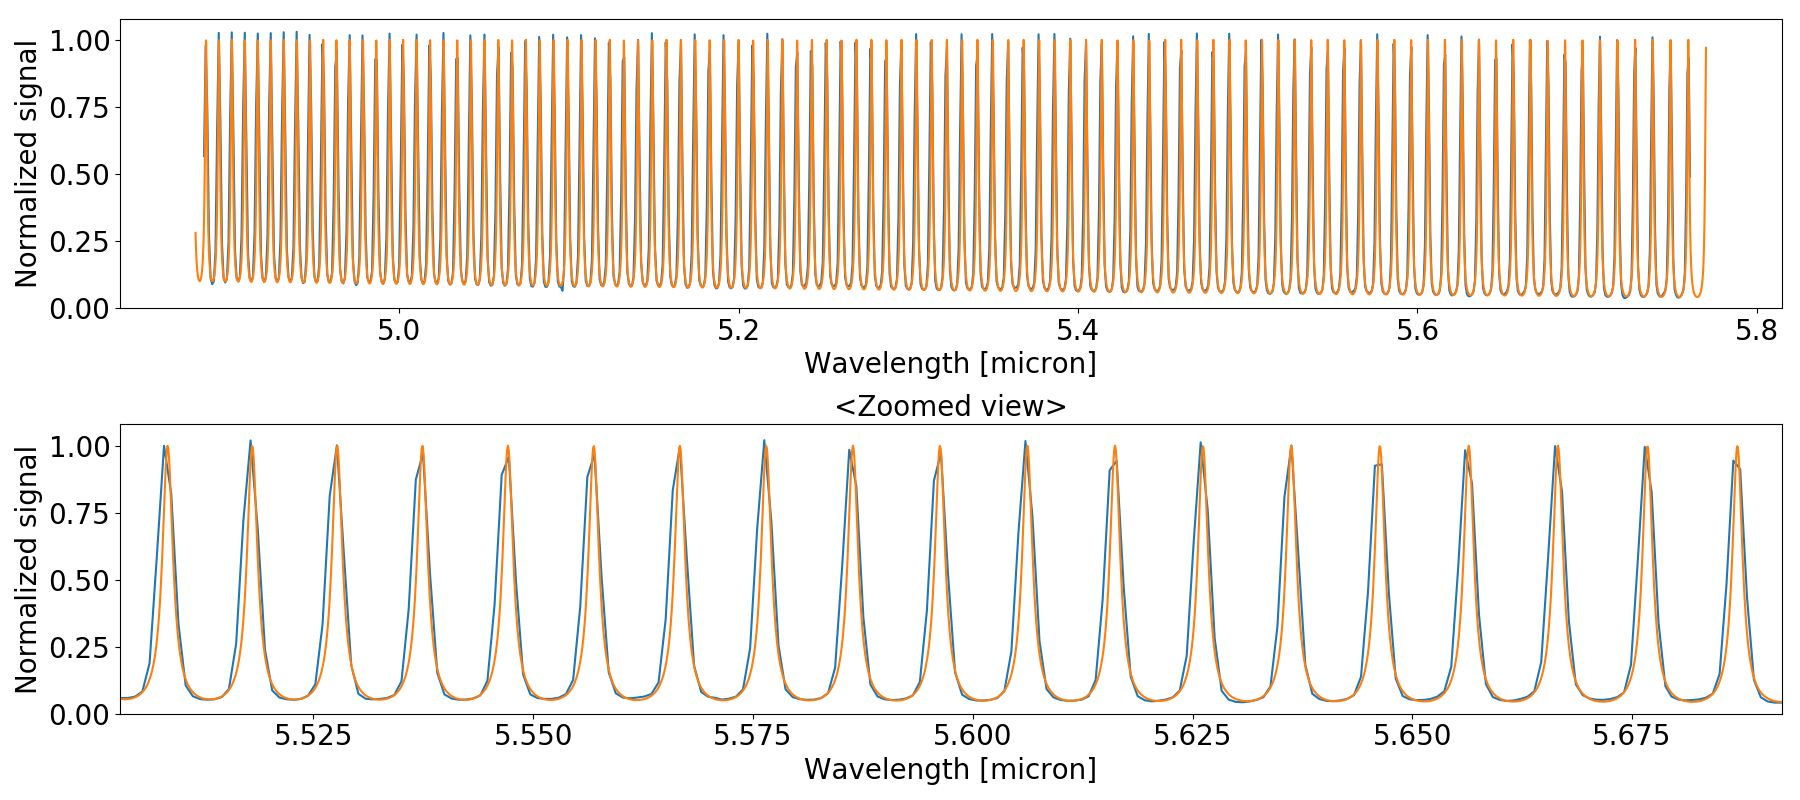

In [12]:
# Let's look at the result
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos]/etal_source_peakprofile)
    axs[plot].plot(wavelengths,flipud(T_e))
    axs[plot].set_ylim(0)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
axs[1].set_xlim(5.503,5.692)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* It was necessary to introduce an additional (constant) phase-shift of ~0.25π to match the etalon line positions (it is difficult to point at a singular cause for why such a phase-shift is needed..)
* The MRS etalon spectrum is modeled well using a Fabry-Pérot resonator transmittance function.

### Test 3: Etalon fringe beating
We have shown how the transmittance function of a Fabry-Pérot resonator can be used to model the etalon ET1A data (or any other etalon data) acquired with the MIRI MRS. This was done by normalizing by a spline taken through the etalon transmission peaks. A clear disadvantage of such an approach is that we are not taking into account the beating seen in the data, in fact we are consciously erasing that signature, via the employed normalization. We retrace our steps a bit here to deal with that issue. Instead of normalizing with a spline through the etalon peaks, we normalize by a spline taken through the beating peaks. This is presumably the **true** spectral baseline of the blackbody spectrum (observed through ET1A).

In [13]:
# Peaks in previously-derived spline
npixels = 1024; npeaks = 8
etal_source_peakprofile_peaks = funcs.find_peaks(etal_source_peakprofile, thres=0., min_dist=npixels/npeaks/2)
# Take univariate spline through the fitted peaks <== THIS IS THE REAL SPECTRAL BASELINE
interpolator = InterpolatedUnivariateSpline(lambdaMap[ypos,xpos][etal_source_peakprofile_peaks],etal_source_peakprofile[etal_source_peakprofile_peaks],k=3,ext=0)
etal_source_peakprofile_profile = interpolator(lambdaMap[ypos,xpos])

<IPython.core.display.Javascript object>


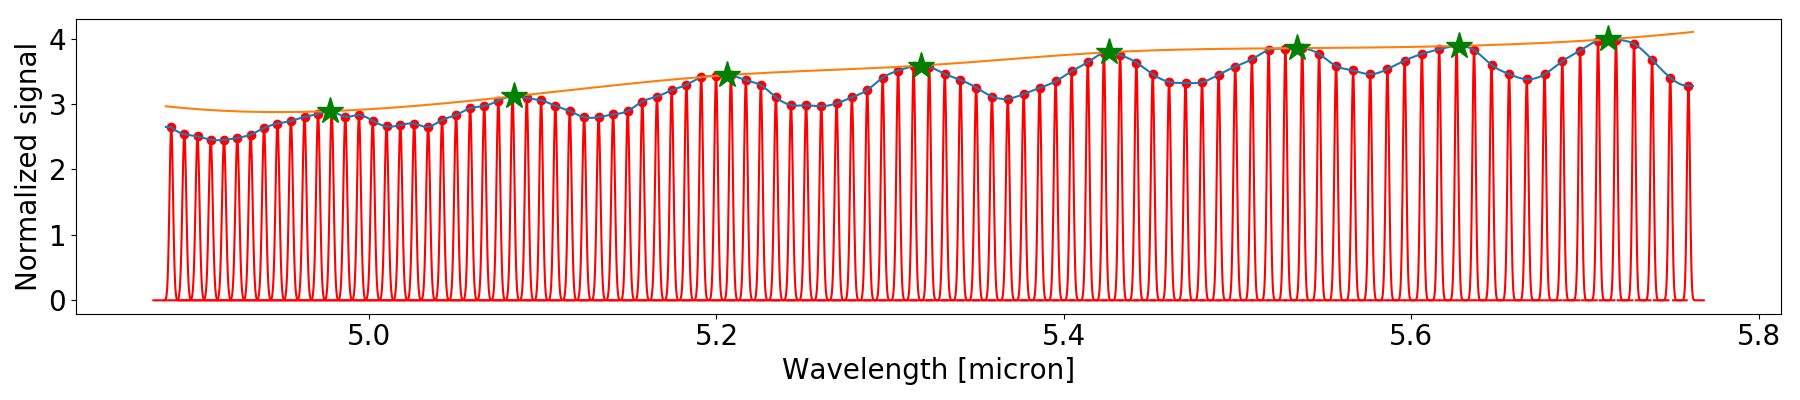

<IPython.core.display.Javascript object>


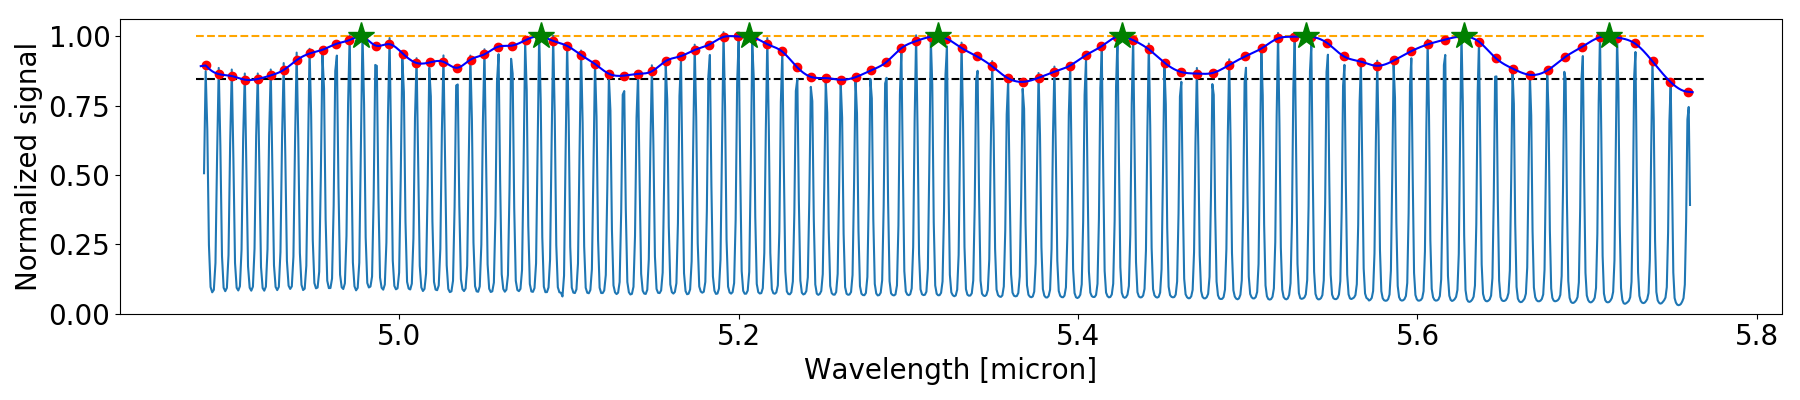

In [14]:
# Let's look at the results
plt.figure(figsize=(18,4))
funcs.plot_etalon_fit(fitparams=fitparams,fitting_flag=fitting_flag)
plt.plot(linecenters,lineheights,'ro')
plt.plot(lambdaMap[ypos,xpos],etal_source_peakprofile)
plt.plot(lambdaMap[ypos,xpos],etal_source_peakprofile_profile)
plt.plot(lambdaMap[ypos,xpos][etal_source_peakprofile_peaks],etal_source_peakprofile[etal_source_peakprofile_peaks],'g*',markersize=20)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos]/etal_source_peakprofile_profile)
plt.plot(linecenters,lineheights/interpolator(linecenters),'ro')
plt.plot(lambdaMap[ypos,xpos],etal_source_peakprofile/etal_source_peakprofile_profile,'b')
plt.plot(lambdaMap[ypos,xpos][etal_source_peakprofile_peaks],etal_source_peakprofile[etal_source_peakprofile_peaks]/interpolator(lambdaMap[ypos,xpos][etal_source_peakprofile_peaks]),'g*',markersize=20)
plt.hlines(1,4.88,5.77,'orange',linestyle='dashed')
plt.hlines(0.846,4.88,5.77,'k',linestyle='dashed')
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [15]:
# compute minima separation (to determine optical thickness of beating component)
beatingminima_wavelength      = lambdaMap[ypos,xpos][etal_source_peakprofile_peaks] # microns
beatingminima_wavenumber      = flipud(10000./beatingminima_wavelength)            # cm-1
mean_beatingminima_separation = mean(diff(beatingminima_wavenumber))
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,beatingminima_wavenumber[:-1],diff(beatingminima_wavenumber))

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_beatingminima_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_beatingminima_separation),2) )
print r'The error on the optical thickness D of the etalon is: -{}um +{}um'.format(round(10000./(2*mean_beatingminima_separation) - 10000./(2*diff(beatingminima_wavenumber)[-1]),2 ),round(10000./(2*diff(beatingminima_wavenumber)[0]) - 10000./(2*mean_beatingminima_separation),2) )
print r'The beating fringe is produced by an etalon with an optical thickness: D = {}+{} um = {} um'.format(round(10000./(2*mean_linecenter_separation),2),round(10000./(2*mean_beatingminima_separation),2),round(10000./(2*mean_beatingminima_separation) + 10000./(2*mean_linecenter_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 36.95 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 135.31 um
The error on the optical thickness D of the etalon is: -15.93um +52.79um
The beating fringe is produced by an etalon with an optical thickness: D = 1578.86+135.31 um = 1714.17 um


<IPython.core.display.Javascript object>


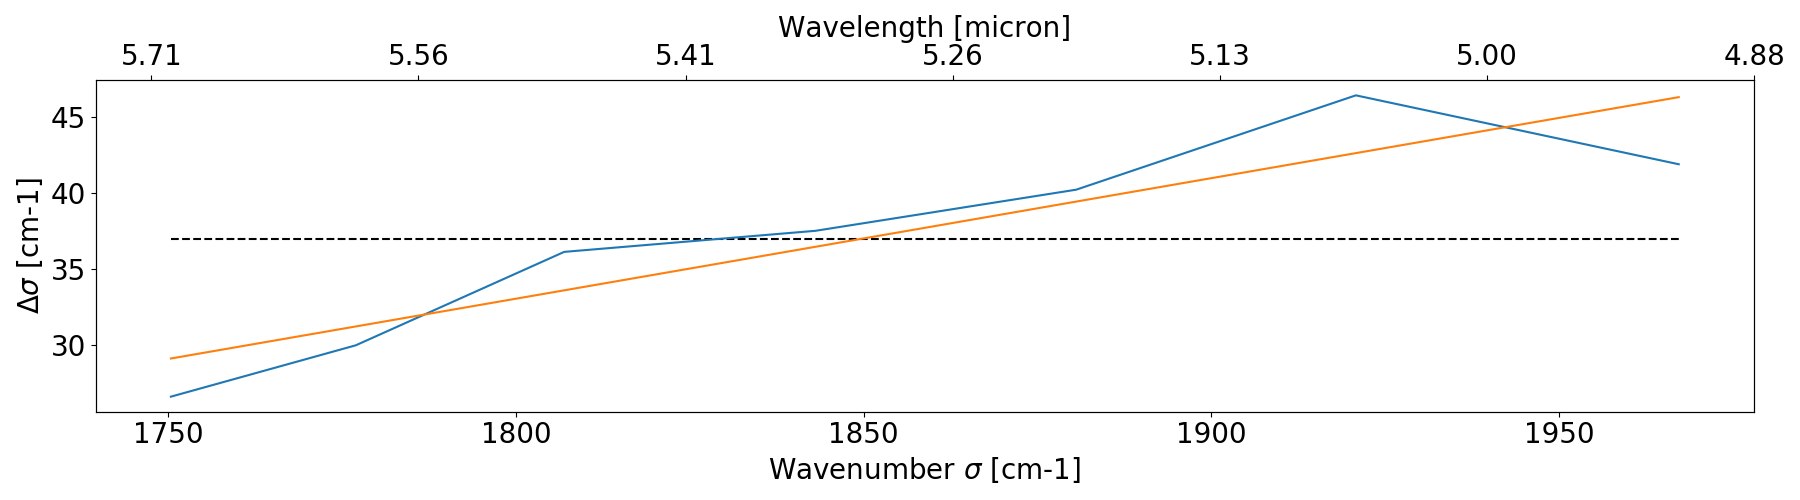

In [16]:
# Let's look at the results
fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(beatingminima_wavenumber[:-1],diff(beatingminima_wavenumber))
axs1.plot(beatingminima_wavenumber[:-1],funcs.straight_line(beatingminima_wavenumber[:-1],*popt))
axs1.hlines(mean_beatingminima_separation,beatingminima_wavenumber[0],beatingminima_wavenumber[-2],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The computed beating minima separation yields a linear variation of the optical thickness that is too large to expect any kind of good modeling of the beating using a simple (constant) mean optical thickness. We show this below anyway, for illustration purposes. What we show is the product of two transmittance functions, with corresponding optical properties computed from the data.

In [17]:
# from the depth of the minima caused by the beating we can determine the reflectivity of the etalon producing the beating fringe
T_e1 = 0.846
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e1)
print ' Finesse = {} \n R1 = {} \n R2 = {} (physically valid solution)'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_beatingfringe = R_solution2

 Finesse = 0.182033096927 
 R1 = 23.93 
 R2 = 0.04 (physically valid solution)


In [18]:
D_beatingfringe = 1/(2*mean_beatingminima_separation) + 1/(2*mean_linecenter_separation) # cm
phi = pi+0.8 # rad

T_e_beatingfringe = funcs.FPfunc(wavenumbers,R_beatingfringe,D_beatingfringe,phi)         # [-]

<IPython.core.display.Javascript object>


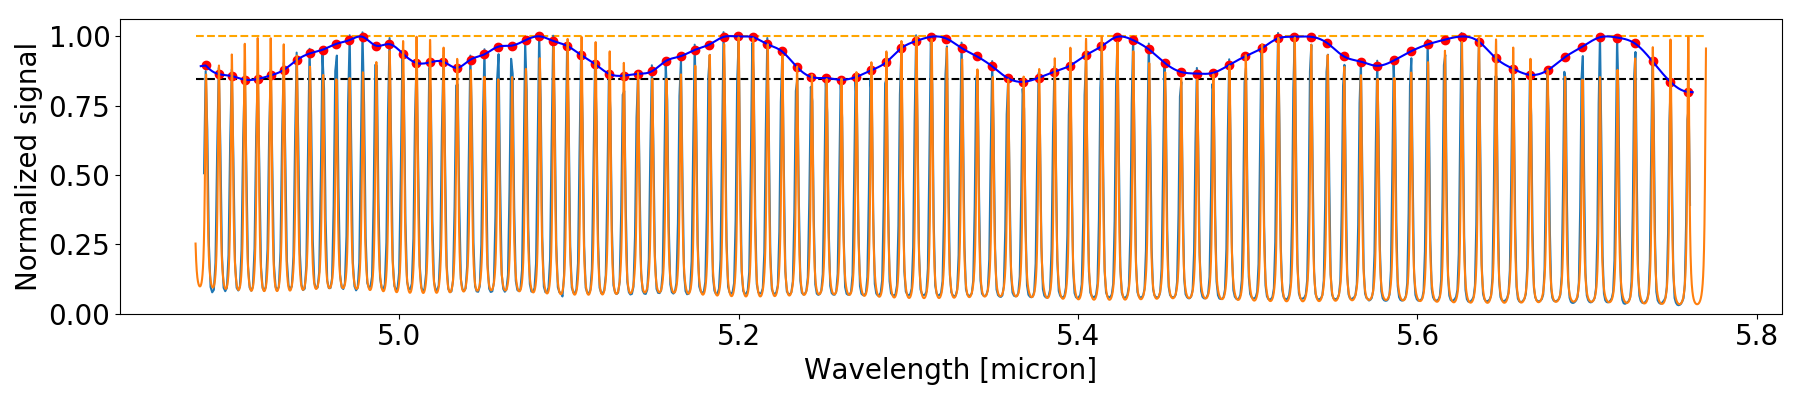

In [19]:
# Let's look at the results
plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],etal_source_oddevencorr[ypos,xpos]/etal_source_peakprofile_profile)
plt.plot(linecenters,lineheights/interpolator(linecenters),'ro')
plt.plot(lambdaMap[ypos,xpos],etal_source_peakprofile/etal_source_peakprofile_profile,'b')
plt.plot(wavelengths,flipud(T_e*T_e_beatingfringe))
plt.hlines(1,4.88,5.77,'orange',linestyle='dashed')
plt.hlines(0.846,4.88,5.77,'k',linestyle='dashed')
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

### Remarks:
* As mentioned before, the uncertainty on the optical thickness of the beating fringe results in a sub-optimal modelization of the system.

## Conclusions:  
* The rationale behind the concept of fringe "transmission" was presented using MRS etalon data. This kind of data is easier to work with because the transmission peaks are more clearly defined (i.e. resolved).
* One can learn a lot about the properties of the etalon by analysing the data, properties such as the optical thickness and apparent reflectivity of the etalon.
* Due to the spectral resolution of the MRS, it is possible to constrain the optical thickness of the used etalon, but not the real reflectivity. A slight decrease in the line separation was found for longer wavelengths (unknown cause). The resulting blending of the unresolved etalon lines causes an apparent/fictitious increase of the etalon reflectivity.
* MRS etalon data show a beating pattern across the transmission peaks. This beating is found to be caused by an etalon with an optical thickness of ~1700um (Spoilers: This is the optical thickness of the MIRI SW detectors, thus the beating is attributed to the interaction of the light interference caused by etalon ET1A and the light interference caused by the MIRI SW detector).

## Follow-up question:  
How do point source etalon data compare to extended source etalon data?